## Imports
We load NumPy for array math, pandas for tables, Matplotlib for plots, SciPy's stats module for reliability quantiles, and CVXPY for solving the convex dispatch problem.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp
from typing import Dict, Any, Tuple

## Production System Class
This class randomly generates a fleet of convex generators. Parameters: `n_machines` controls fleet size, `seed` ensures reproducibility, `alpha/beta/gamma_bounds` define the cost coefficients, and `capacity_bounds` set min/max outputs. Methods `describe()` and `total_capacity()` summarize the fleet.

In [59]:
class ProductionSystem:
    """
    Holds the convex generator fleet (cost curves + capacity bounds).
    """
    def __init__(self, n_machines: int = 5, seed: int = 42,
                 alpha_bounds: Tuple[float, float] = (0.05, 0.2),
                 beta_bounds: Tuple[float, float] = (2.0, 5.0),
                 gamma_bounds: Tuple[float, float] = (10.0, 20.0),
                 capacity_bounds: Tuple[float, float] = (50.0, 150.0)):
        rng = np.random.default_rng(seed)
        self.n = n_machines
        
        # Quadratic coefficients cost(x) = alpha x^2 + beta x + gamma
        self.alpha = rng.uniform(alpha_bounds[0], alpha_bounds[1], n_machines)
        self.beta = rng.uniform(beta_bounds[0], beta_bounds[1], n_machines)
        self.gamma = rng.uniform(gamma_bounds[0], gamma_bounds[1], n_machines)
        
        # Lower/upper capacity bounds (MW)
        self.l = np.zeros(n_machines)
        self.u = rng.uniform(capacity_bounds[0], capacity_bounds[1], n_machines)
        
    def describe(self) -> pd.DataFrame:
        machines = np.arange(1, self.n + 1)
        data = {
            "alpha": self.alpha,
            "beta": self.beta,
            "gamma": self.gamma,
            "min_cap": self.l,
            "max_cap": self.u,
        }
        return pd.DataFrame(data, index=machines).rename_axis("machine")
        
    def total_capacity(self) -> float:
        return float(np.sum(self.u))

## Economic Dispatch Solver
`solve_dispatch` enforces chance constraints. Inputs: `system` (fleet), `mu_D`/`sigma_D` (demand stats), `reliability` (probability level), and `mode` (Gaussian vs. Chebyshev). It builds CVXPY variable `x`, computes effective demand `D_eff`, sets up the quadratic cost objective, enforces capacity/demand constraints, solves, and returns primal/dual results.

In [60]:
def solve_dispatch(
    system: ProductionSystem,
    mu_D: float,
    sigma_D: float,
    reliability: float = 0.95,
    mode: str = "normal",
) -> Dict[str, Any]:
    """Solve the stochastic economic dispatch under Gaussian or Chebyshev risk."""
    
    if sigma_D < 0 or mu_D < 0:
        raise ValueError("Demand statistics must be non-negative")
    if not 0.0 < reliability < 1.0:
        raise ValueError("Reliability must lie strictly between 0 and 1")
    
    x = cp.Variable(system.n)
    alpha_risk = 1.0 - reliability
    
    if mode == "normal":
        z_score = stats.norm.ppf(reliability)
        D_eff = mu_D + z_score * sigma_D
    elif mode == "robust":
        k_robust = np.sqrt((1 - alpha_risk) / alpha_risk)
        D_eff = mu_D + k_robust * sigma_D
    else:
        raise ValueError("Mode must be 'normal' or 'robust'")
    
    if D_eff > system.total_capacity() + 1e-6:
        raise ValueError("Effective demand exceeds installed capacity")
    
    objective = cp.Minimize(
        cp.sum(cp.multiply(system.alpha, x**2) + cp.multiply(system.beta, x))
    )
    
    c_demand = [cp.sum(x) >= D_eff]
    c_upper = [x <= system.u]
    c_lower = [x >= system.l]
    constraints = c_demand + c_upper + c_lower
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)
    
    if prob.status not in {"optimal", "optimal_inaccurate"}:
        return {"status": prob.status}
    
    dispatch = x.value
    total_cost = float(
        np.sum(system.alpha * dispatch**2 + system.beta * dispatch + system.gamma)
    )
    
    return {
        "status": prob.status,
        "x": dispatch,
        "cost": total_cost,
        "objective": prob.value,
        "D_eff": float(D_eff),
        "lambda": c_demand[0].dual_value,
        "nu_u": c_upper[0].dual_value,
        "nu_l": c_lower[0].dual_value,
    }

## KKT Verification
`verify_kkt` receives the system and solver results, computes the stationarity residual (`grad_f - λ + ν⁺ - ν⁻`) and complementary slackness (`(∑x - D_eff) * λ`), prints both, and reports whether they are below tolerance.

In [61]:
def verify_kkt(system: ProductionSystem, res: Dict[str, Any], tol: float = 1e-4) -> Dict[str, float]:
    """Compute stationarity and complementary slackness residuals."""
    
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        print("Cannot verify KKT: solution unavailable.")
        return {}
    
    dispatch = res["x"]
    lam = res["lambda"]
    nu_u = res["nu_u"]
    nu_l = res["nu_l"]
    
    grad_f = 2 * system.alpha * dispatch + system.beta
    stationarity_residual = grad_f - lam + nu_u - nu_l
    max_stationarity = float(np.max(np.abs(stationarity_residual)))
    
    total_prod = float(np.sum(dispatch))
    slack = total_prod - res["D_eff"]
    comp_slack_error = float(abs(slack * lam))
    
    print("\n--- KKT CHECK ---")
    print(f"Stationarity residual: {max_stationarity:.2e}")
    print(f"Complementary slackness residual: {comp_slack_error:.2e}")
    
    if max_stationarity < tol and comp_slack_error < tol:
        print("KKT conditions satisfied within tolerance.")
    else:
        print("Warning: residuals exceed tolerance.")
    
    return {"stationarity": max_stationarity, "slackness": comp_slack_error}

## Dispatch Summary Table
`summarize_dispatch` merges the machine parameters with solution outputs: dispatch MW, slack to bounds, dual multipliers (`nu_upper`, `nu_lower`), marginal cost, and slice of total cost per generator.

In [62]:
def summarize_dispatch(system, res):
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        raise ValueError("Cannot summarize infeasible solution")

    dispatch = res["x"]
    table = system.describe().copy()
    table["dispatch"] = dispatch
    table["upper_slack"] = system.u - dispatch
    table["lower_slack"] = dispatch - system.l
    table["nu_upper"] = res["nu_u"]
    table["nu_lower"] = res["nu_l"]
    table["marginal_cost"] = 2 * system.alpha * dispatch + system.beta
    table["incremental_cost"] = system.alpha * dispatch**2 + system.beta * dispatch + system.gamma
    return table

In [63]:
# 1. Create the factory
my_factory = ProductionSystem(n_machines=5)

# 2. Define the scenario
MEAN_DEMAND = 300
SIGMA = 30
RELIABILITY = 0.95  # 95% sure we won't fail

# 3. Run the Normal Model
print("--- RUNNING NORMAL MODEL ---")
res_normal = solve_dispatch(
    my_factory, MEAN_DEMAND, SIGMA, reliability=RELIABILITY, mode="normal"
)
print(f"Total Cost: ${res_normal['cost']:,.2f}")
print(f"Production Target: {res_normal['D_eff']:.2f} Units")

# 4. Run the Robust Model
print("\n--- RUNNING ROBUST MODEL ---")
res_robust = solve_dispatch(
    my_factory, MEAN_DEMAND, SIGMA, reliability=RELIABILITY, mode="robust"
)
print(f"Total Cost: ${res_robust['cost']:,.2f}")
print(f"Production Target: {res_robust['D_eff']:.2f} Units")

# 5. Verify the Math
verify_kkt(my_factory, res_normal)

--- RUNNING NORMAL MODEL ---
Total Cost: $4,305.68
Production Target: 349.35 Units

--- RUNNING ROBUST MODEL ---
Total Cost: $6,336.46
Production Target: 430.77 Units

--- KKT CHECK ---
Stationarity residual: 3.52e-13
Complementary slackness residual: 1.23e-12
KKT conditions satisfied within tolerance.


{'stationarity': 3.5216274341109965e-13, 'slackness': 1.2315451736330222e-12}

## Scenario Comparison
We instantiate a 6-machine system, set demand statistics (`mu_D`, `sigma_D`) and reliability, then solve under both Gaussian (`normal`) and Chebyshev (`robust`) assumptions. For each mode we store results, show effective demand, cost, a preview of the dispatch table, and run the KKT check.

In [64]:
# Scenario comparison for Gaussian vs. Chebyshev hedging
system = ProductionSystem(n_machines=6, seed=7)
mu_D = 350.0
sigma_D = 40.0
reliability = 0.95

print("Generator parameters (USD & MW):")
print(system.describe())

results = {}
summaries = {}
for mode in ("normal", "robust"):
    print(f"\n=== {mode.title()} dispatch ===")
    res = solve_dispatch(system, mu_D, sigma_D, reliability=reliability, mode=mode)
    results[mode] = res
    summary = summarize_dispatch(system, res)
    summaries[mode] = summary
    print(f"Effective demand: {res['D_eff']:.1f} MW")
    print(f"Total cost: ${res['cost']:.2f}")
    print(summary[["dispatch", "max_cap", "marginal_cost"]])
    verify_kkt(system, res)

Generator parameters (USD & MW):
            alpha      beta      gamma  min_cap     max_cap
machine                                                    
1        0.143764  2.015796  12.548696      0.0  112.217923
2        0.184582  4.463685  14.450763      0.0  148.896015
3        0.166353  4.391208  15.045483      0.0   71.530870
4        0.083781  3.403805  15.534974      0.0   66.021203
5        0.095025  2.909097  19.955003      0.0  111.253960
6        0.181033  2.835277  17.926619      0.0   54.394201

=== Normal dispatch ===
Effective demand: 415.8 MW
Total cost: $5359.32
           dispatch     max_cap  marginal_cost
machine                                       
1         75.517454  112.217923      23.729227
2         52.186926  148.896015      23.729227
3         58.123495   71.530870      23.729227
4         66.021203   66.021203      14.466460
5        109.550866  111.253960      23.729227
6         54.394201   54.394201      22.529569

--- KKT CHECK ---
Stationarity residu

## Visualization
We compare dispatch levels between modes via grouped bars and overlay dashed lines at each machine’s capacity (`system.u`).

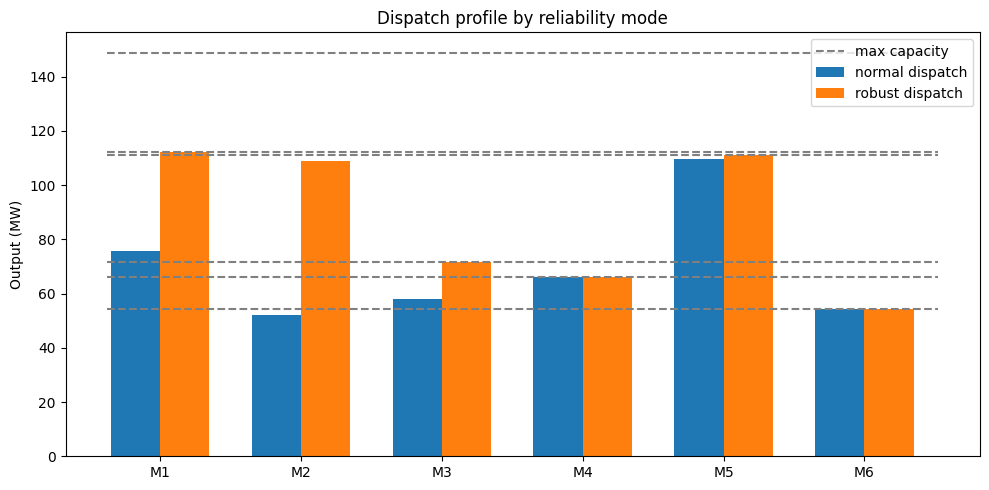

In [65]:
# Visual comparison of dispatch decisions
modes = list(summaries.keys())
indices = np.arange(system.n)
width = 0.35

plt.figure(figsize=(10, 5))
for i, mode in enumerate(modes):
    plt.bar(indices + i * width, summaries[mode]["dispatch"], width, label=f"{mode} dispatch")

plt.hlines(system.u, xmin=-0.2, xmax=indices[-1] + len(modes) * width, colors="gray", linestyles="dashed", label="max capacity")
plt.xticks(indices + width / 2, [f"M{i+1}" for i in indices])
plt.ylabel("Output (MW)")
plt.title("Dispatch profile by reliability mode")
plt.legend()
plt.tight_layout()
plt.show()

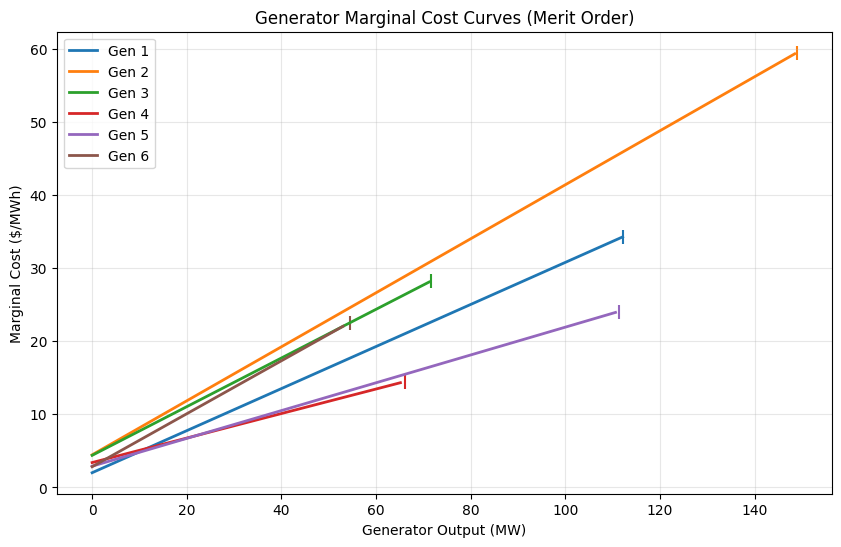

In [66]:
def plot_marginal_costs(system):
    """Plot marginal cost curves (2ax + b) for all generators."""
    x_vals = np.linspace(0, 150, 100)
    plt.figure(figsize=(10, 6))
    
    # Plot MC for each machine
    for i in range(system.n):
        # Marginal Cost = derivative of cost function = 2*alpha*x + beta
        mc = 2 * system.alpha[i] * x_vals + system.beta[i]
        
        # Only plot up to the machine's max capacity
        valid_idx = x_vals <= system.u[i]
        plt.plot(x_vals[valid_idx], mc[valid_idx], linewidth=2, label=f"Gen {i+1}")
        
        # Mark the max capacity point
        max_mc = 2 * system.alpha[i] * system.u[i] + system.beta[i]
        plt.scatter([system.u[i]], [max_mc], marker='|', s=100)

    plt.xlabel("Generator Output (MW)")
    plt.ylabel("Marginal Cost ($/MWh)")
    plt.title("Generator Marginal Cost Curves (Merit Order)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_marginal_costs(system)

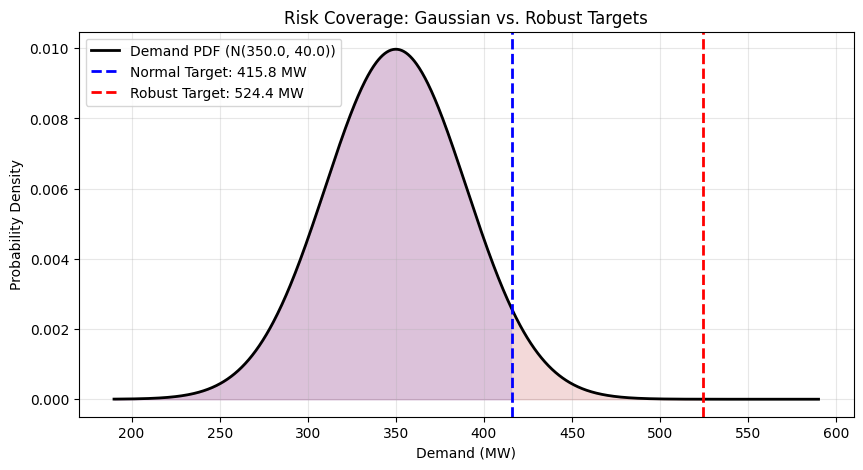

In [67]:
def plot_risk_distributions(mu, sigma, results):
    """Visualize Gaussian demand distribution vs optimization targets."""
    x = np.linspace(mu - 4*sigma, mu + 6*sigma, 1000)
    y = stats.norm.pdf(x, mu, sigma)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'k-', lw=2, label=f'Demand PDF (N({mu}, {sigma}))')
    plt.fill_between(x, y, alpha=0.1, color='gray')
    
    # Plot Effective Demands (Targets)
    modes = [('normal', 'blue'), ('robust', 'red')]
    for mode, color in modes:
        deff = results[mode]['D_eff']
        plt.axvline(deff, color=color, linestyle='--', linewidth=2, 
                   label=f'{mode.title()} Target: {deff:.1f} MW')
        
        # Shade the "risk" area covered
        plt.fill_between(x, y, where=(x <= deff), color=color, alpha=0.1)

    plt.xlabel("Demand (MW)")
    plt.ylabel("Probability Density")
    plt.title("Risk Coverage: Gaussian vs. Robust Targets")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_risk_distributions(mu_D, sigma_D, results)

Calculating supply curve...


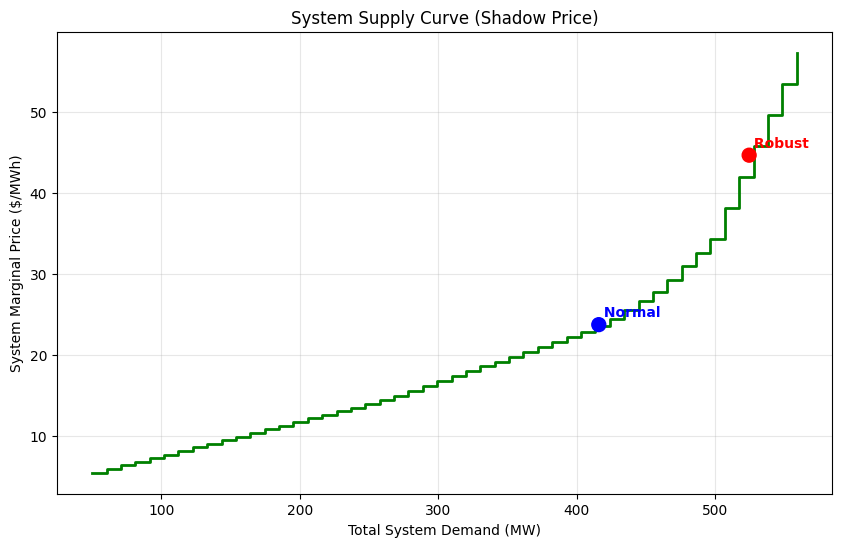

In [68]:
def plot_supply_curve(system):
    """Sweep demand from 0 to max capacity to map the system price (lambda)."""
    demands = np.linspace(50, system.total_capacity() * 0.99, 50)
    prices = []
    
    print("Calculating supply curve...")
    for d in demands:
        # Solve dispatch with 0 variance (deterministic) to find pure marginal price
        res = solve_dispatch(system, d, 0, mode="normal")
        if res['status'] == 'optimal':
            prices.append(res['lambda'])
        else:
            prices.append(None)
            
    plt.figure(figsize=(10, 6))
    plt.step(demands, prices, where='post', color='green', linewidth=2)
    plt.xlabel("Total System Demand (MW)")
    plt.ylabel("System Marginal Price ($/MWh)")
    plt.title("System Supply Curve (Shadow Price)")
    plt.grid(True, alpha=0.3)
    
    # Annotate current scenarios
    current_demands = [results['normal']['D_eff'], results['robust']['D_eff']]
    current_prices = [results['normal']['lambda'], results['robust']['lambda']]
    plt.scatter(current_demands, current_prices, color=['blue', 'red'], zorder=5, s=100)
    plt.text(current_demands[0], current_prices[0]+1, " Normal", color='blue', fontweight='bold')
    plt.text(current_demands[1], current_prices[1]+1, " Robust", color='red', fontweight='bold')
    
    plt.show()

plot_supply_curve(system)


<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
C:\Users\visha\AppData\Local\Temp\ipykernel_43408\4007328186.py:18: SyntaxWarning: invalid escape sequence '\g'
  ax1.bar(modes, fixed_costs, label='Fixed ($\gamma$)', color='lightgray')


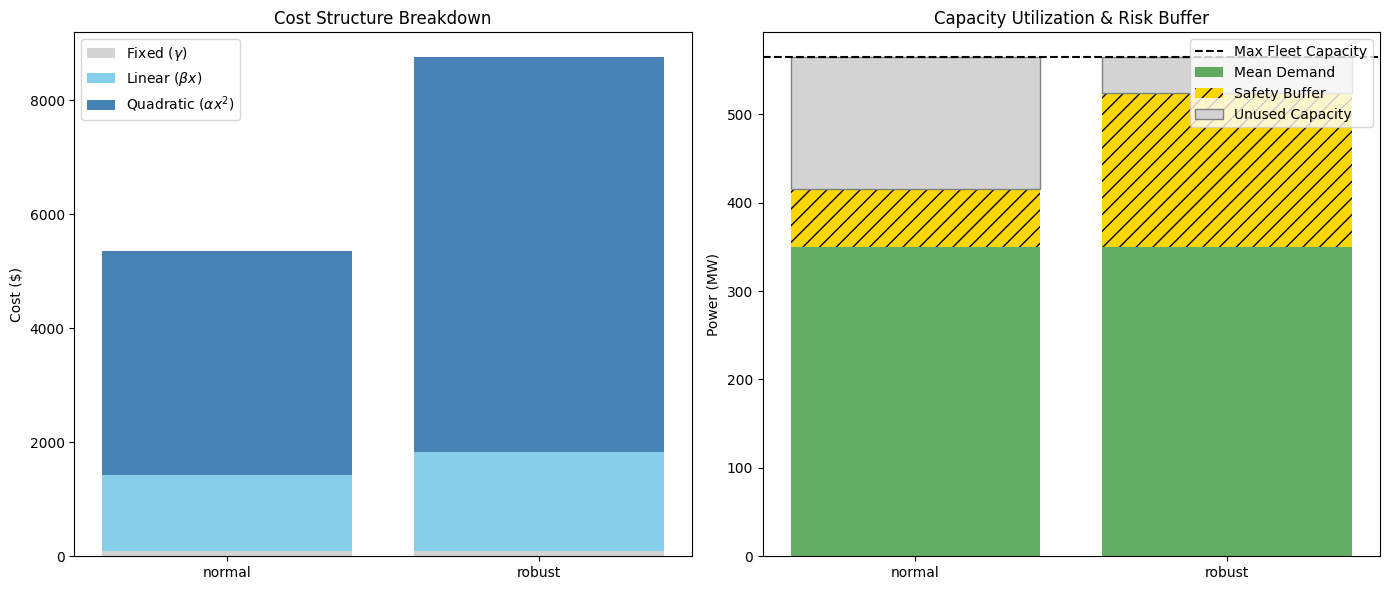

In [69]:
def plot_dashboard(system, results, mu_D):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    modes = ['normal', 'robust']
    
    # --- Chart 1: Cost Structure ---
    # Extract cost components
    fixed_costs = []
    linear_costs = []
    quad_costs = []
    
    for mode in modes:
        x = results[mode]['x']
        fixed_costs.append(np.sum(system.gamma))
        linear_costs.append(np.sum(system.beta * x))
        quad_costs.append(np.sum(system.alpha * x**2))
        
    # Stacked bar chart
    ax1.bar(modes, fixed_costs, label='Fixed ($\gamma$)', color='lightgray')
    ax1.bar(modes, linear_costs, bottom=fixed_costs, label='Linear ($\\beta x$)', color='skyblue')
    # Calculate bottom for quadratic
    bot_quad = np.array(fixed_costs) + np.array(linear_costs)
    ax1.bar(modes, quad_costs, bottom=bot_quad, label='Quadratic ($\\alpha x^2$)', color='steelblue')
    
    ax1.set_title("Cost Structure Breakdown")
    ax1.set_ylabel("Cost ($)")
    ax1.legend(loc='upper left')
    
    # --- Chart 2: Safety Gap Analysis ---
    # Components: Mean Demand, Buffer, Unused Capacity
    total_cap = system.total_capacity()
    means = [mu_D, mu_D]
    buffers = [results[m]['D_eff'] - mu_D for m in modes]
    unused = [total_cap - results[m]['D_eff'] for m in modes]
    
    ax2.bar(modes, means, label='Mean Demand', color='forestgreen', alpha=0.7)
    ax2.bar(modes, buffers, bottom=means, label='Safety Buffer', color='gold', hatch='//')
    # Bottom for unused
    bot_unused = np.array(means) + np.array(buffers)
    ax2.bar(modes, unused, bottom=bot_unused, label='Unused Capacity', color='lightgray', edgecolor='gray')
    
    ax2.set_title("Capacity Utilization & Risk Buffer")
    ax2.set_ylabel("Power (MW)")
    ax2.axhline(total_cap, color='k', linestyle='--', label='Max Fleet Capacity')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_dashboard(system, results, mu_D)